# Import Necessary Libraries and read datasets

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import plotly.graph_objects as go
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import colors as mcolors
from scipy.stats import linregress
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors

%matplotlib inline

In [2]:
# Initialize Plotly for use in the notebook
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

In [3]:
customers = pd.read_csv('Customers.csv')
products = pd.read_csv('Products.csv')
transactions = pd.read_csv('Transactions.csv')

In [4]:
df = pd.merge(transactions, customers.drop('CustomerName', axis='columns'), on='CustomerID')
df = pd.merge(df, products.drop('Price', axis='columns'), on='ProductID')
df.head()

,TransactionID,CustomerID,ProductID,TransactionDate,Quantity,TotalValue,Price,Region,SignupDate,ProductName,Category
0,T00001,C0199,P067,2024-08-25 12:38:23,1,300.68,300.68,Europe,2022-12-03,ComfortLiving Bluetooth Speaker,Electronics
1,T00112,C0146,P067,2024-05-27 22:23:54,1,300.68,300.68,Asia,2024-09-04,ComfortLiving Bluetooth Speaker,Electronics
2,T00166,C0127,P067,2024-04-25 07:38:55,1,300.68,300.68,Europe,2024-04-04,ComfortLiving Bluetooth Speaker,Electronics
3,T00272,C0087,P067,2024-03-26 22:55:37,2,601.36,300.68,South America,2024-04-11,ComfortLiving Bluetooth Speaker,Electronics
4,T00363,C0070,P067,2024-03-21 15:10:10,3,902.04,300.68,Europe,2022-03-15,ComfortLiving Bluetooth Speaker,Electronics


## To build a Lookalike Model that takes a user's information as input and recommends 3 similar customers based on their profile and transaction history, we will use RFM features. RFM is a method used for analyzing customer value and segmenting the customer base. It is an acronym that stands for: Recency(R), Frequency(F), Monetary(M).

In [5]:
df['TransactionDate'] = pd.to_datetime(df['TransactionDate'])
df['SignupDate'] = pd.to_datetime(df['SignupDate'])

### Recency(R): In this step, we focus on understanding how recently a customer has made a purchase.

In [6]:
# Convert TransactionDate to datetime and extract only the date
df['TransactionDay'] = df['TransactionDate'].dt.date

# Find the most recent purchase date for each customer
customer_data = df.groupby('CustomerID')['TransactionDay'].max().reset_index()

# Find the most recent date in the entire dataset
most_recent_date = df['TransactionDay'].max()

# Convert TransactionDay to datetime type before subtraction
customer_data['TransactionDay'] = pd.to_datetime(customer_data['TransactionDay'])
most_recent_date = pd.to_datetime(most_recent_date)

# Calculate the number of days since the last purchase for each customer
customer_data['Days_Since_Last_Purchase'] = (most_recent_date - customer_data['TransactionDay']).dt.days

# Remove the TransactionDay column
customer_data.drop(columns=['TransactionDay'], inplace=True)

customer_data.head()

,CustomerID,Days_Since_Last_Purchase
0,C0001,56
1,C0002,25
2,C0003,126
3,C0004,5
4,C0005,54


### Frequency(F): In this step, I am going to create two features that quantify the frequency of a customer's engagement with the retailer.

In [7]:
# Calculate the total number of transactions made by each customer
total_transactions = df.groupby('CustomerID')['TransactionID'].nunique().reset_index()
total_transactions.rename(columns={'TransactionID': 'Total_Transactions'}, inplace=True)

# Calculate the total number of products purchased by each customer
total_products_purchased = df.groupby('CustomerID')['Quantity'].sum().reset_index()
total_products_purchased.rename(columns={'Quantity': 'Total_Products_Purchased'}, inplace=True)

# Merge the new features into the customer_data dataframe
customer_data = pd.merge(customer_data, total_transactions, on='CustomerID')
customer_data = pd.merge(customer_data, total_products_purchased, on='CustomerID')

customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased
0,C0001,56,5,12
1,C0002,25,4,10
2,C0003,126,4,14
3,C0004,5,8,23
4,C0005,54,3,7


### Monetary(M): In this step, I am going to create two features that represent the monetary aspect of customer's transactions.

In [8]:
# Calculate the total spend by each customer
total_spend = df.groupby('CustomerID')['TotalValue'].sum().reset_index()

# Calculate the average transaction value for each customer
average_transaction_value = total_spend.merge(total_transactions, on='CustomerID')
average_transaction_value['Average_Transaction_Value'] = average_transaction_value['TotalValue'] / average_transaction_value['Total_Transactions']

# Merge the new features into the customer_data dataframe
customer_data = pd.merge(customer_data, total_spend, on='CustomerID')
customer_data = pd.merge(customer_data, average_transaction_value[['CustomerID', 'Average_Transaction_Value']], on='CustomerID')

customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,TotalValue,Average_Transaction_Value
0,C0001,56,5,12,3354.52,670.904
1,C0002,25,4,10,1862.74,465.685
2,C0003,126,4,14,2725.38,681.345
3,C0004,5,8,23,5354.88,669.360
4,C0005,54,3,7,2034.24,678.080


### Product Diversity

In [9]:
# Calculate the number of unique products purchased by each customer
unique_products_purchased = df.groupby('CustomerID')['ProductID'].nunique().reset_index()
unique_products_purchased.rename(columns={'ProductID': 'Unique_Products_Purchased'}, inplace=True)

# Merge the new feature into the customer_data dataframe
customer_data = pd.merge(customer_data, unique_products_purchased, on='CustomerID')

customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,TotalValue,Average_Transaction_Value,Unique_Products_Purchased
0,C0001,56,5,12,3354.52,670.904,5
1,C0002,25,4,10,1862.74,465.685,4
2,C0003,126,4,14,2725.38,681.345,4
3,C0004,5,8,23,5354.88,669.360,8
4,C0005,54,3,7,2034.24,678.080,3


In [10]:
# Changing the data type of 'CustomerID' to string as it is a unique identifier and not used in mathematical operations
customer_data['CustomerID'] = customer_data['CustomerID'].astype(str)

# Convert data types of columns to optimal types
customer_data = customer_data.convert_dtypes()

customer_data.head(10)

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,TotalValue,Average_Transaction_Value,Unique_Products_Purchased
0,C0001,56,5,12,3354.52,670.904,5
1,C0002,25,4,10,1862.74,465.685,4
2,C0003,126,4,14,2725.38,681.345,4
3,C0004,5,8,23,5354.88,669.36,8
4,C0005,54,3,7,2034.24,678.08,3
5,C0006,82,4,12,4227.57,1056.8925,4
6,C0007,125,3,8,2579.82,859.94,3
7,C0008,11,10,20,4271.61,427.161,10
8,C0009,77,3,3,896.5,298.833333,3
9,C0010,42,4,12,1717.55,429.3875,4


In [11]:
customer_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199 entries, 0 to 198
Data columns (total 7 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   CustomerID                 199 non-null    string 
 1   Days_Since_Last_Purchase   199 non-null    Int64  
 2   Total_Transactions         199 non-null    Int64  
 3   Total_Products_Purchased   199 non-null    Int64  
 4   TotalValue                 199 non-null    Float64
 5   Average_Transaction_Value  199 non-null    Float64
 6   Unique_Products_Purchased  199 non-null    Int64  
dtypes: Float64(2), Int64(4), string(1)
memory usage: 12.2 KB


### Correlational Analysis

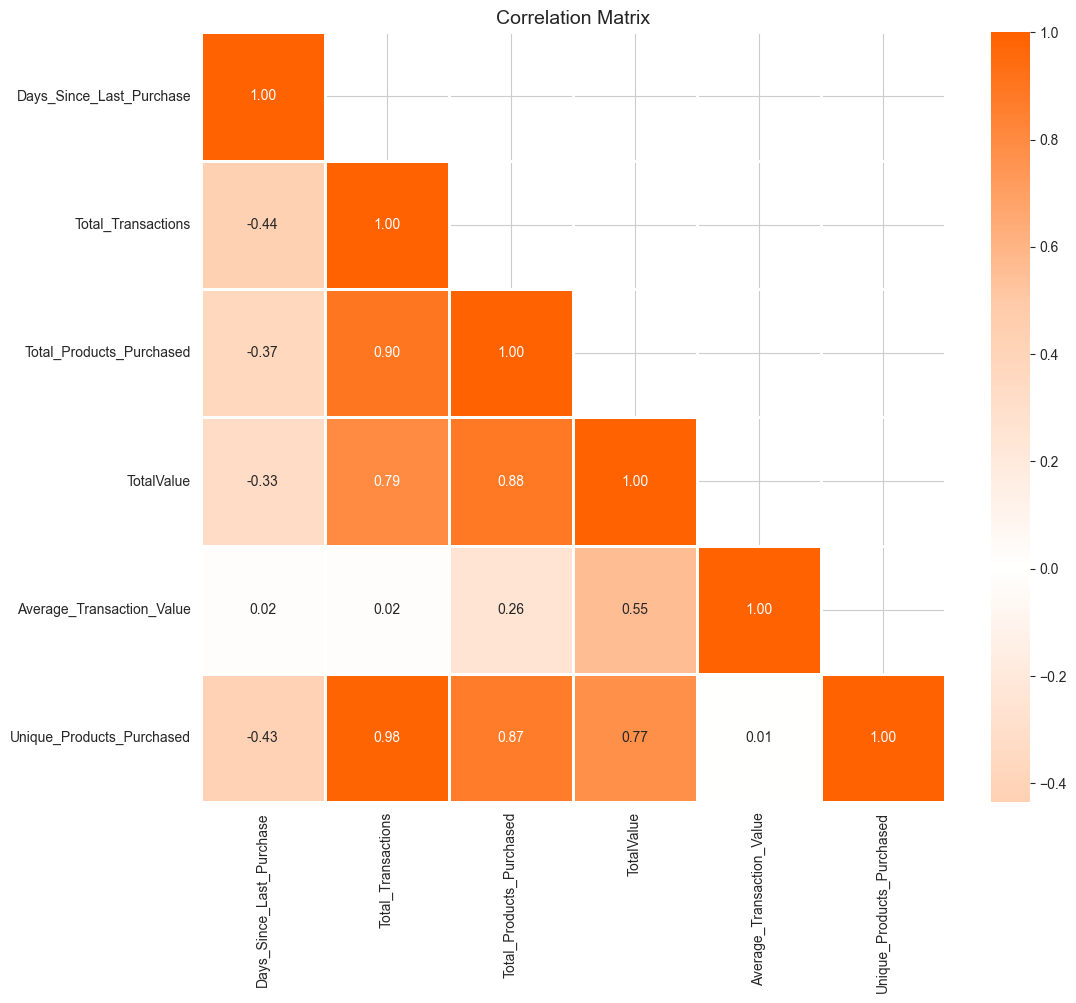

In [12]:
# Reset background style
sns.set_style('whitegrid')

# Calculate the correlation matrix excluding the 'CustomerID' column
corr = customer_data.drop(columns=['CustomerID']).corr()

# Define a custom colormap
colors = ['#ff6200', '#ffcaa8', 'white', '#ffcaa8', '#ff6200']
my_cmap = LinearSegmentedColormap.from_list('custom_map', colors, N=256)

# Create a mask to only show the lower triangle of the matrix (since it's mirrored around its 
# top-left to bottom-right diagonal)
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask, k=1)] = True

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr, mask=mask, cmap=my_cmap, annot=True, center=0, fmt='.2f', linewidths=2)
plt.title('Correlation Matrix', fontsize=14)
plt.show()

### Feature Scaling

In [13]:
# Initialize the StandardScaler
scaler = StandardScaler()

# List of columns that don't need to be scaled
columns_to_exclude = ['CustomerID']

# List of columns that need to be scaled
columns_to_scale = customer_data.columns.difference(columns_to_exclude)

# Copy the cleaned dataset
customer_data_scaled = customer_data.copy()

# Applying the scaler to the necessary columns in the dataset
customer_data_scaled[columns_to_scale] = scaler.fit_transform(customer_data_scaled[columns_to_scale])

customer_data_scaled.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,TotalValue,Average_Transaction_Value,Unique_Products_Purchased
0,C0001,-0.261180,-0.011458,-0.122033,-0.061701,-0.070263,0.050047
1,C0002,-0.699369,-0.467494,-0.448000,-0.877744,-0.934933,-0.424204
2,C0003,0.728278,-0.467494,0.203934,-0.405857,-0.026271,-0.424204
3,C0004,-0.982071,1.356650,1.670787,1.032547,-0.076769,1.472798
4,C0005,-0.289450,-0.923530,-0.936951,-0.783929,-0.040028,-0.898455


### Dimensionality Reduction using PCA

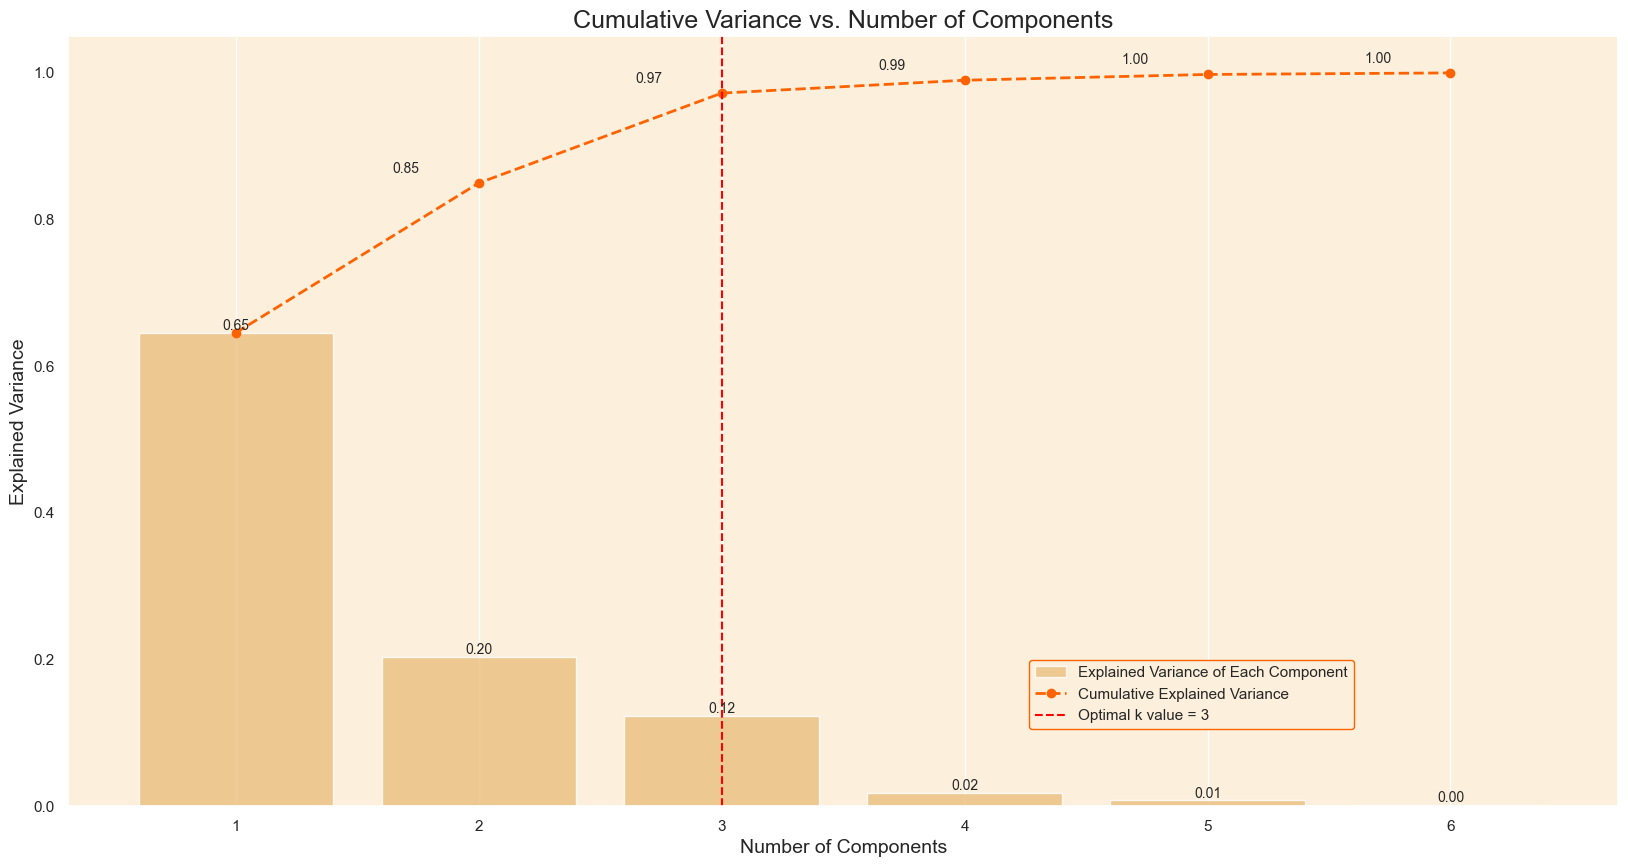

In [14]:
# Apply PCA
pca = PCA().fit(customer_data_scaled.drop('CustomerID', axis='columns'))

# Calculate the Cumulative Sum of the Explained Variance
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

# Set the optimal k value (based on our analysis, we can choose 3)
optimal_k = 3

# Set seaborn plot style
sns.set(rc={'axes.facecolor': '#fcf0dc'}, style='darkgrid')

# Plot the cumulative explained variance against the number of components
plt.figure(figsize=(20, 10))

# Bar chart for the explained variance of each component
barplot = sns.barplot(x=list(range(1, len(cumulative_explained_variance) + 1)),
                      y=explained_variance_ratio,
                      color='#fcc36d',
                      alpha=0.8)

# Line plot for the cumulative explained variance
lineplot, = plt.plot(range(0, len(cumulative_explained_variance)), cumulative_explained_variance,
                     marker='o', linestyle='--', color='#ff6200', linewidth=2)

# Plot optimal k value line
optimal_k_line = plt.axvline(optimal_k - 1, color='red', linestyle='--', label=f'Optimal k value = {optimal_k}')

# Set labels and title
plt.xlabel('Number of Components', fontsize=14)
plt.ylabel('Explained Variance', fontsize=14)
plt.title('Cumulative Variance vs. Number of Components', fontsize=18)

# Customize ticks and legend
plt.xticks(range(0, len(cumulative_explained_variance)))
plt.legend(handles=[barplot.patches[0], lineplot, optimal_k_line],
           labels=['Explained Variance of Each Component', 'Cumulative Explained Variance', f'Optimal k value = {optimal_k}'],
           loc=(0.62, 0.1),
           frameon=True,
           framealpha=1.0,  
           edgecolor='#ff6200')

# Display the variance values for both graphs on the plots
x_offset = -0.3
y_offset = 0.01
for i, (ev_ratio, cum_ev_ratio) in enumerate(zip(explained_variance_ratio, cumulative_explained_variance)):
    plt.text(i, ev_ratio, f"{ev_ratio:.2f}", ha="center", va="bottom", fontsize=10)
    if i > 0:
        plt.text(i + x_offset, cum_ev_ratio + y_offset, f"{cum_ev_ratio:.2f}", ha="center", va="bottom", fontsize=10)

plt.grid(axis='both')   
plt.show()

In [15]:
# Creating a PCA object with 3 components
pca = PCA(n_components=3)

# Fitting and transforming the original data to the new PCA dataframe
customer_data_pca = pca.fit_transform(customer_data_scaled.drop('CustomerID', axis='columns'))

# Creating a new dataframe from the PCA dataframe, with columns labeled PC1, PC2, etc.
customer_data_pca = pd.DataFrame(customer_data_pca, columns=['PC'+str(i+1) for i in range(pca.n_components_)])

# Adding the CustomerID index back to the new PCA dataframe
customer_data_pca['CustomerID'] = customer_data_scaled['CustomerID']

# Displaying the resulting dataframe based on the PCs
customer_data_pca.head()

,PC1,PC2,PC3,CustomerID
0,-0.011581,-0.178932,-0.228933,C0001
1,-1.001908,-1.129527,-0.638001,C0002
2,-0.711337,0.283387,0.512732,C0003
3,2.894169,-0.573878,-0.035399,C0004
4,-1.625527,-0.043407,-0.769466,C0005


### Nearest Neighbors Model Training

In [16]:
knn = NearestNeighbors(n_neighbors=4, metric='euclidean')  # 4 includes the customer itself
knn.fit(customer_data_pca.drop('CustomerID', axis='columns'))

NearestNeighbors(metric='euclidean', n_neighbors=4)

In [17]:
distances, indices = knn.kneighbors(customer_data_pca.drop('CustomerID', axis='columns'))

### Similarity score is Euclidean Distance. Less the score, more the similarity.

In [18]:
distances

array([[0.        , 0.225119  , 0.30559309, 0.32619366],
       [0.        , 0.20842716, 0.31511126, 0.33650373],
       [0.        , 0.35977083, 0.67862637, 0.68406226],
       [0.        , 0.39201004, 0.49386139, 0.60604719],
       [0.        , 0.22278706, 0.43646562, 0.51564924],
       [0.        , 0.78961091, 0.79311717, 0.79592853],
       [0.        , 0.29191073, 0.66288861, 0.67289181],
       [0.        , 0.88836482, 1.35560414, 1.4094261 ],
       [0.        , 0.42304848, 0.58643107, 0.71604337],
       [0.        , 0.31511126, 0.34266728, 0.42854615],
       [0.        , 0.3276144 , 0.41355417, 0.47814729],
       [0.        , 0.25642594, 0.27000803, 0.45673902],
       [0.        , 0.5352781 , 0.61545607, 0.63880806],
       [0.        , 0.37329486, 1.18853188, 1.97656072],
       [0.        , 0.32217947, 0.49869659, 0.5321097 ],
       [0.        , 0.1621561 , 0.36689316, 0.36702374],
       [0.        , 0.20720155, 0.2191678 , 0.58090798],
       [0.        , 0.63778603,

In [19]:
indices

array([[  0, 151, 106,  71],
       [  1,  30,   9,  28],
       [  2, 124,  34,  51],
       [  3,  67, 100,  16],
       [  4,  35, 184, 131],
       [  5,  25, 185, 157],
       [  6, 119, 166,  84],
       [  7,  83,  16, 146],
       [  8,  76,  42,  31],
       [  9,   1,  30, 197],
       [ 10,  47,  63, 136],
       [ 11, 121,  50, 168],
       [ 12, 154,  45, 142],
       [ 13,  57,  96, 127],
       [ 14,  94,  62, 196],
       [ 15, 181, 106,  47],
       [ 16, 161, 112,  83],
       [ 17, 169, 148,  99],
       [ 18, 171, 115, 110],
       [ 19, 109,  79, 143],
       [ 20, 161,  92, 112],
       [ 21, 152, 104,  99],
       [ 22,  52, 125, 168],
       [ 23, 192,  89,  33],
       [ 24, 190,  70,  42],
       [ 25, 157,  69, 134],
       [ 26,  34, 165, 176],
       [ 27, 186,  40,  98],
       [ 28,   1,  30, 141],
       [ 29,  37, 187,  85],
       [ 30,   1,   9, 197],
       [ 31,  82,  76,   8],
       [ 32,  59, 127,  96],
       [ 33, 192,  80, 178],
       [ 34,  

### Top 3 similar customers

In [20]:
customer_ids = customer_data_pca['CustomerID'][:20]
lookalike_results = {}

for cust_id in customer_ids:
    idx = customer_data_pca.index[customer_data_pca['CustomerID'] == cust_id][0]
    similar_customers = sorted([(customer_data_pca.iloc[i]['CustomerID'], distances[idx][j]) 
                               for j, i in enumerate(indices[idx]) if i != idx], key=lambda x: x[1])
    
    # Store only top 3 lookalikes
    lookalike_results[cust_id] = similar_customers[:3]

# Convert to DataFrame for CSV export
lookalike_df = pd.DataFrame([
    {'cust_id': key, 
     'lookalike_1': value[0][0], 'score_1': value[0][1],
     'lookalike_2': value[1][0], 'score_2': value[1][1],
     'lookalike_3': value[2][0], 'score_3': value[2][1]}
    for key, value in lookalike_results.items()
])

# Save results to Yuvam_Kothari_Lookalike.csv
lookalike_df.to_csv('Yuvam_Kothari_Lookalike.csv', index=False)

print("Lookalike model results saved to Yuvam_Kothari_Lookalike.csv")

Lookalike model results saved to Yuvam_Kothari_Lookalike.csv


In [21]:
lookalike = pd.read_csv('Yuvam_Kothari_Lookalike.csv')
lookalike.head()

,cust_id,lookalike_1,score_1,lookalike_2,score_2,lookalike_3,score_3
0,C0001,C0152,0.225119,C0107,0.305593,C0072,0.326194
1,C0002,C0031,0.208427,C0010,0.315111,C0029,0.336504
2,C0003,C0125,0.359771,C0035,0.678626,C0052,0.684062
3,C0004,C0068,0.392010,C0101,0.493861,C0017,0.606047
4,C0005,C0036,0.222787,C0186,0.436466,C0132,0.515649


### Less the score more is similarity between customers